In [230]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.5)

In [57]:
#Create connection and cursor
conn = psycopg2.connect("dbname=pfxbaseballdata")
cur = conn.cursor()

In [58]:
# Define query
query = """
SELECT * 
FROM batter_stats_table AS B
INNER JOIN player_id_table AS IB on IB.fg_id = B.playerid
INNER JOIN test_pitches AS GD on IB.mlb_id = GD.batter_id
INNER JOIN player_id_table AS IP on IP.mlb_id = GD.pitcher_id
INNER JOIN pitcher_stats_table AS P on P.playerid = IP.fg_id;
"""
#Execute the query
cur.execute(query)
# Return the next row
GameData = cur.fetchall()

In [70]:
GameData_df = pd.DataFrame(GameData, columns=['b_name', 'b_team', 'b_games', 'PA', 'HR', 'R', 'RBI', 'SB',
                                             'BB_percent', 'K_percent','b_ISO', 'b_BABIP', 'BA_AVG', 'OBP', 'SLG', 'wOBA',
                                              'WRC_plus', 'BSR', 'OFF', 'DEF', 'WAR', 'b_playerid',
                                              'b_mlb_id', 'b_mlb_name', 'b_mlb_pos', 'b_mlb_team', 'b_mlb_team_full',
                                              'b_bats', 'batter_throws', 'b_birth_year', 'b_bp_id', 'b_bref_id', 
                                              'b_bref_name','b_cbs_id', 'b_cbs_name', 'b_cbs_pos', 'b_espn_id', 
                                              'b_espn_name','b_espn_pos','b_fg_id','b_fg_name','b_fg_pos',
                                              'b_lahman_id', 'b_nfbc_id','b_nfbc_name','b_nfbc_pos','b_retro_id', 
                                              'b_retro_name', 'b_debut', 'b_yahoo_id','b_yahoo_name',
                                              'b_yahoo_pos','b_mlb_depth', 'b_ottoneu_id', 'b_ottoneu_name', 
                                              'b_ottoneu_pos','dataStamp', 'park_sv_id', 'play_guid', 'ab_total', 
                                              'ab_count','pitcher_id', 'batter_id', 'ab_id', 'des', 'pitcher_type',
                                              'pitch_id', 'sz_top', 'sz_bot', 'pfx_xDataFile', 'pfx_zDataFile',
                                              'mlbam_pitch_name', 'zone_location', 'pitch_con', 'stand',
                                              'strikes', 'balls', 'p_throws', 'gid', 'pdes', 'spin', 'norm_ht',
                                              'inning', 'pitcher_team', 'tstart', 'vystart', 'ftime', 'pfx_x',
                                              'pfx_z', 'uncorrected_pfx_x', 'uncorrected_pfx_z', 'x0',
                                              'y0', 'z0', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'start_speed',
                                              'px', 'pz', 'pxold', 'pzold', 'tm_spin', 'sb', 'p_mlb_id',
                                              'p_mlb_name', 'p_mlb_pos', 'p_mlb_team','p_mlb_team_full', 'p_bats', 
                                              'pfx_p_throws','p_birth_year', 'p_bp_id', 'p_bref_id', 'p_bref_name', 
                                              'p_cbs_id', 'p_cbs_name','p_cbs_pos', 'p_espn_id', 'p_espn_name', 
                                              'p_espn_pos', 
                                              'p_fg_id','p_fg_name','p_fg_pos', 'p_lahman_id', 'p_nfbc_id', 'p_nfbc_name', 
                                              'p_nfbc_pos', 'p_retro_id','p_retro_name', 'p_debut', 'p_yahoo_id', 'p_yahoo_name', 
                                              'p_yahoo_pos','p_mlb_depth', 'p_ottoneu_id', 'p_ottoneu_name', 'p_ottoneu_pos', 
                                              'p_name',
                                              'p_team', 'p_wins', 'p_losses', 'p_saves', 'p_games', 'p_games_started', 'p_innings_pitched',
                                              'p_k_per_9', 'p_bb_per_9', 'p_hr_per_9', 'p_babip', 'p_lob_percent',
                                              'p_gb_percent', 'p_hr_fb_percent', 'p_era', 'p_fip', 'p_xfip', 'p_war',
                                              'p_playerid'])

In [175]:
cleanGameData_df

,b_games,PA,HR,R,RBI,SB,BB_percent,K_percent,b_ISO,b_BABIP,...,p_era,p_fip,p_xfip,p_war,p_playerid,batter_stance,pitcher_handedness,pitch_outcome,hit_prediction,hit_probability
0,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0,0.016414
1,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0,0.016414
2,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0,0.016414
3,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0,0.016414
4,809,2994,59,304,346,21,0.085,0.195,0.141,0.298,...,3.46,3.78,4.11,2.0,9975,0,1,0,0,0.018530
5,809,2994,59,304,346,21,0.085,0.195,0.141,0.298,...,3.46,3.78,4.11,2.0,9975,0,1,0,0,0.018529
6,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,0,0,0.017061
7,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,0,0,0.017061
8,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,1,0,0.017061
9,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,1,0,0.017061


In [185]:
cleanGameData_df = GameData_df.loc[:,['b_games', 'PA', 'HR', 'R', 'RBI', 'SB',
                                    'BB_percent', 'K_percent','b_ISO', 'b_BABIP', 'BA_AVG', 'OBP', 'SLG', 'wOBA',
                                    'WRC_plus', 'BSR', 'OFF', 'DEF', 'WAR', 'b_playerid','b_mlb_id', 
                                    'b_fg_id','b_debut', 'ab_total', 'ab_count','pitcher_id', 
                                    'batter_id', 'ab_id','pitch_id', 'sz_top', 'sz_bot', 'pfx_xDataFile', 
                                    'pfx_zDataFile', 'pitch_con','strikes', 'balls', 'spin', 
                                    'norm_ht','inning','tstart', 'vystart', 'ftime', 'pfx_x','pfx_z', 
                                    'uncorrected_pfx_x','uncorrected_pfx_z', 'x0','y0', 'z0', 'vx0', 'vy0', 'vz0', 
                                    'ax', 'ay', 'az','start_speed','px', 'pz', 'pxold', 'pzold', 'tm_spin', 'sb', 
                                    'p_mlb_id','p_birth_year','p_fg_id','p_debut', 'p_wins', 'p_losses', 
                                    'p_saves','p_games', 'p_games_started', 'p_innings_pitched','p_k_per_9', 
                                    'p_bb_per_9','p_hr_per_9', 'p_babip', 'p_lob_percent','p_gb_percent', 
                                    'p_hr_fb_percent','p_era', 'p_fip', 'p_xfip', 'p_war','p_playerid']]

In [186]:
batter_stance = []
for batter in GameData_df.loc[:,]['stand']:
    if batter == 'R':
        batter_stance.append(1)
    else:
        batter_stance.append(0)
cleanGameData_df['batter_stance'] = batter_stance

In [187]:
right_left_handness = []
for pitcher in GameData_df.loc[:,]['pfx_p_throws']:
    if pitcher == 'R':
        right_left_handness.append(1)
    else:
        right_left_handness.append(0)
cleanGameData_df['pitcher_handedness'] = right_left_handness

In [203]:
for pitch in GameData_df.loc[:,]['pdes']:
    if 'play' in pitch:
        if 'no' in pitch or 'run' in pitch:
            print(pitch)

In play, no out
In play, no out
In play, run(s)
In play, run(s)
In play, no out
In play, no out
In play, no out
In play, no out
In play, run(s)
In play, run(s)
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, run(s)
In play, run(s)
In play, run(s)
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, run(s)
In play, run(s)
In play, run(s)
In play, run(s)
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, no out
In play, run(s)
In play, no out
In play, no out
In play, run(s)
In play, run(s)
In play, no out
In play, no out
In play, no out
In play, no out
In play, run(s)
In play, run(s)
In play, run(s)
In play, run(s)
In play,

In [189]:
#Binary Outcome for logistic regression
outcome = [] 
for pitch in GameData_df.loc[:,]['pdes']:
    if 'play' in pitch:
        if 'no' in pitch or 'run' in pitch:
            outcome.append(1) #1 indicates hit
        else:
            outcome.append(0)
    else:
        outcome.append(0) #0 indicates a non-hit outcome
cleanGameData_df['pitch_outcome'] = outcome

In [211]:
#Binary Outcome for logistic regression
ab_outcome = [] 
ball_in_play = ['Single', 'Double', 'Triple', 'Home Run']
for pitch in GameData_df.loc[:,]['des']:
    if pitch in ball_in_play and 'Play' not in pitch:
        ab_outcome.append(1)
    else:
        ab_outcome.append(0)
cleanGameData_df['ab_outcome'] = ab_outcome 

In [199]:
cleanGameData_df['pitch_outcome']

0       0
1       0
2       0
3       0
4       1
5       1
6       0
7       0
8       1
9       1
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
3269    0
3270    0
3271    0
3272    1
3273    0
3274    0
3275    0
3276    1
3277    0
3278    1
3279    0
3280    0
3281    0
3282    0
3283    0
3284    0
3285    1
3286    0
3287    0
3288    0
3289    0
3290    1
3291    1
3292    0
3293    0
3294    0
3295    0
3296    0
3297    0
3298    0
Name: pitch_outcome, Length: 3299, dtype: int64

In [212]:
cleanGameData_df

,b_games,PA,HR,R,RBI,SB,BB_percent,K_percent,b_ISO,b_BABIP,...,p_era,p_fip,p_xfip,p_war,p_playerid,batter_stance,pitcher_handedness,pitch_outcome,hit_probability,ab_outcome
0,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0.054149,0
1,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0.054147,0
2,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0.054142,0
3,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.46,3.78,4.11,2.0,9975,1,1,0,0.054142,0
4,809,2994,59,304,346,21,0.085,0.195,0.141,0.298,...,3.46,3.78,4.11,2.0,9975,0,1,1,0.061501,1
5,809,2994,59,304,346,21,0.085,0.195,0.141,0.298,...,3.46,3.78,4.11,2.0,9975,0,1,1,0.061493,1
6,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,0,0.054308,1
7,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,0,0.054308,1
8,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,1,0.054309,1
9,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.46,3.78,4.11,2.0,9975,1,1,1,0.054308,1


In [214]:
# fit a logistic regression model and store the class predictions
logreg = LogisticRegression(C=1e9)
X = np.array(cleanGameData_df.iloc[:,0:87])
y = np.array(cleanGameData_df['ab_outcome'])
logreg.fit(X, y)
hit_proba = logreg.predict_proba(X)
basic_log_score = logreg.score(X, y)


In [223]:
hit_probability = []
for i in hit_proba:
    hit_probability.append(i[1])

In [224]:
cleanGameData_df['ab_hit_probability'] = hit_probability

In [225]:
cleanGameData_df['ab_outcome'].mean()

0.2003637465898757

In [226]:
basic_log_score

0.79963625341012423

In [228]:
cleanGameData_df['ab_hit_probability'].max()

0.25124646781737781

In [229]:
cleanGameData_df

,b_games,PA,HR,R,RBI,SB,BB_percent,K_percent,b_ISO,b_BABIP,...,p_fip,p_xfip,p_war,p_playerid,batter_stance,pitcher_handedness,pitch_outcome,hit_probability,ab_outcome,ab_hit_probability
0,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.78,4.11,2.0,9975,1,1,0,0.171175,0,0.171175
1,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.78,4.11,2.0,9975,1,1,0,0.171125,0,0.171125
2,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.78,4.11,2.0,9975,1,1,0,0.170956,0,0.170956
3,899,3692,116,443,527,14,0.093,0.120,0.169,0.322,...,3.78,4.11,2.0,9975,1,1,0,0.170955,0,0.170955
4,809,2994,59,304,346,21,0.085,0.195,0.141,0.298,...,3.78,4.11,2.0,9975,0,1,1,0.182095,1,0.182095
5,809,2994,59,304,346,21,0.085,0.195,0.141,0.298,...,3.78,4.11,2.0,9975,0,1,1,0.181826,1,0.181826
6,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.78,4.11,2.0,9975,1,1,0,0.175244,1,0.175244
7,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.78,4.11,2.0,9975,1,1,0,0.175218,1,0.175218
8,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.78,4.11,2.0,9975,1,1,1,0.175254,1,0.175254
9,555,1839,34,224,187,105,0.053,0.136,0.129,0.301,...,3.78,4.11,2.0,9975,1,1,1,0.175218,1,0.175218


Text(0,0.5,'y')

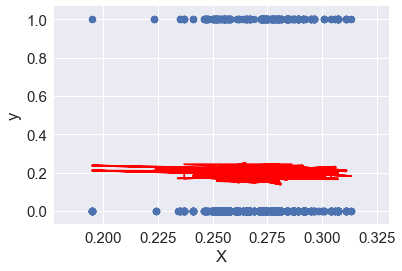